In [ ]:

import os
import yaml
import torch
import random
import logging
import statistics
import cv2
import numpy as np

import matplotlib.pyplot as plt
import torchvision.transforms as T
from accelerate import Accelerator
from yacs.config import CfgNode as CN
from main import get_config, init_accelerator, set_seed, FFPP
from src.models import VPT, remap_weight, enable_gradients
logging.basicConfig(level="DEBUG")

num_frames = 1


class Obj:
    pass

In [13]:
# LINEAR PROBE
# cfg_path = "logs/test/iconic-durian-1140/setting.yaml"

# S1(50,5s1f,v1)+linear(6k)+adamw(1e-2)
# cfg_path = "logs/test/olive-water-1118/setting.yaml"

# S1(20,5s1f,v1)+linear(6k)+adamw(1e-2)
cfg_path = "logs/test/peachy-haze-1123/setting.yaml"

# S1(20,5s1f,v1,rrc)+linear(9k)+adamw(1e-2)
# cfg_path = "logs/test/vocal-bee-1132/setting.yaml"

# S1(10,5s1f,v1)+linear(6k)+adamw(1e-2)
# cfg_path = "logs/test/summer-vortex-1139/setting.yaml"

# S1(20,5s1f,v1,NT)+linear(6k)+adamw(1e-2)
# cfg_path = "logs/test/feasible-morning-1133/setting.yaml"


with open(cfg_path) as f:
    preset = CN(yaml.safe_load(f))

mc = VPT.get_default_config().merge_from_other_cfg(preset.model)
mc.attn_record = True

accelerator = Accelerator(mixed_precision='no')

model = VPT(mc, num_frames, accelerator).to(accelerator.device)
encoder = model.encoder
model.load_state_dict(
    torch.load(
        os.path.join(os.path.split(cfg_path)[0], "best_weights.pt"),
        map_location="cpu"
    )
)


model.eval()
model = model.to("cuda")
mc

CfgNode({'name': 'VPT', 'out_dim': [2], 'losses': ['auc_roc'], 'frame_prompts': 20, 'dropout': 0.5, 'weight_decay': 0.01, 'optimizer': 'adamw', 'attn_record': True, 'architecture': 'ViT-B/16'})

In [14]:

c = FFPP.get_default_config()
c.pack = 1
c.augmentation = "none"
c.random_speed = False
c.compressions = ["c23"]
# c.types = ["REAL", "FS","F2F","DF"]
# c.types = ["REAL", "NT","FS","F2F","DF"]
# c.types = ["FS"]

transform = T.Compose([
    T.Resize(encoder.input_resolution, interpolation=T.InterpolationMode.BICUBIC),
    T.CenterCrop(encoder.input_resolution),
    T.ConvertImageDtype(torch.float32),
    T.Normalize((0.48145466, 0.4578275, 0.40821073),
                (0.26862954, 0.26130258, 0.27577711)),
])

_transform = T.Compose([
    T.Resize(encoder.input_resolution, interpolation=T.InterpolationMode.BICUBIC),
    T.CenterCrop(encoder.input_resolution),
    T.ConvertImageDtype(torch.float32)
])

# x = FFPP(c.clone(), num_frames, 4, transform, accelerator, split="test")
# _x = FFPP(c.clone(), num_frames, 4, _transform, accelerator, split="test")
# c

In [15]:
c.types = ["FS"]
x = FFPP(c.clone(), num_frames, 4, transform, accelerator, split="test")
data = x[random.randint(0, len(x))]

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:DF TYPES:['FS']
DEBUG:root:DF TYPES:['c23']
DEBUG:root:Item/Video Index:27/8
DEBUG:root:Item DF/COMP:FS/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/FS/c23/videos/418_507.avi
DEBUG:root:Sample Offset: 0
DEBUG:root:Sample Stride: 0
DEBUG:root:Video: ./datasets/ffpp/FS/c23/videos/418_507.avi, Completed!
DEBUG:root:Item/Video Index:28/8
DEBUG:root:Item DF/COMP:FS/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/FS/c23/videos/418_507.avi
DEBUG:root:Sample Offset: 4
DEBUG:root:Sample Stride: 0
DEBUG:root:Video: ./datasets/ffpp/FS/c23/videos/418_507.avi, Completed!
DEBUG:root:Item/Video Index:29/8
DEBUG:root:Item DF/COMP:FS/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/FS/c23/videos/418_507.avi
DEBUG:root:Sample Offset: 8
DEBUG:root:Sample Stride: 0
DEBUG:root:Video: 

In [19]:
import cv2
import numpy as np


def interpret(clip, mask, model, device, start_layer=0, num_layer=-1, logit_index=1, mode="all"):
    torch.cuda.empty_cache()
    enable_gradients(model)
    # duplicate image for further gradient operation to accord to different input sources
    num_patch = model.encoder.input_resolution // model.encoder.patch_size
    task_logits, features = model.predict(clip.unsqueeze(0).to(device))
    clip_logits = task_logits[0]
    probs = clip_logits.softmax(dim=-1).detach().cpu().numpy()
    print("Score:", clip_logits)
    print("Probs:", probs)

    one_hot = np.zeros((1, 1), dtype=np.float32)
    # diagonal matrix
    one_hot[0, 0] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    # only observe the fake logit score
    one_hot = torch.sum(one_hot.cuda() * clip_logits[:, logit_index])

    model.zero_grad()

    image_attn_blocks = list(dict(model.encoder.transformer.resblocks.named_children()).values())

    if start_layer == -1:
        # calculate index of last layer
        start_layer = len(image_attn_blocks) - 1

    if num_layer == -1:
        num_layer = len(image_attn_blocks)

    frame_prompts = max(model.encoder.prompts, 0)
    num_tokens = image_attn_blocks[0].attn.aff.shape[-2]
    num_queries = 1

    # create empty storage
    R = torch.zeros(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn.aff.dtype).to(device)
    # create saliency map for each input-output in interest
    R = R.unsqueeze(0)
    for i in range(start_layer, start_layer + num_layer):
        # calculate the gradient of attn_prob wrt the one_hot score(each pair of text and image)
        # the blk.attn.aff has shape of (12*n, 50, 50), n = batch_size, which is number of texts in this context.
        # 50 = 7*7 + 1, which 7*7 is the number of patches and 1 for the cls token.
        # The grad function will derive the gradient of the attention scores over the heads of the n image corresponding to the texts.
        # In this step, the purpose of duplicating the image according to the number of texts and creating the one_hot diagonal matrix
        # for the similarity score supported the purpose of splitting the affect of the image features corresponding to different texts.
        grad = torch.autograd.grad(
            one_hot,
            [image_attn_blocks[i].attn.aff],
            retain_graph=True
        )[0].detach()

        cam = image_attn_blocks[i].attn.aff.detach()

        if (mode == "grad"):
            cam = grad
        elif (mode == "cam"):
            cam = cam
        elif (mode == "all"):
            cam = grad * cam
        else:
            raise NotImplementedError()

        # reshape to restore (n,h,p^2+1,p^2+1)
        # cam = cam.reshape(1, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.permute((0, 3, 1, 2))

        # average over each heads.
        cam = cam.clamp(min=0).mean(dim=1)

        # the cam represents the multi-head averaged gradient weighted attention score for each frame corresponding to the texts.
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        R = R + cam / num_layer

    # video_relevance = R[:, 0]
    video_relevance = R[:, 0, 1 + frame_prompts:]
    video_relevance = video_relevance.view((num_queries, -1, num_patch, num_patch))
    return video_relevance, probs


def show_clip_relevance(clip, clip_relevance, q=0):
    clip_relevance = clip_relevance[q]
    # create heatmap from mask on image

    def show_cam_on_clip(clip, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255

        cam = heatmap + np.float32(clip)
        cam = cam / np.max(cam)
        return cam

    dim = int(clip_relevance.shape[-1])
    # process clip relevance map
    clip_relevance = clip_relevance.unsqueeze(1)
    clip_relevance = torch.nn.functional.interpolate(clip_relevance, size=224, mode='bilinear').cpu().numpy()
    clip_relevance = (clip_relevance - clip_relevance.min()) / (clip_relevance.max() - clip_relevance.min())
    # process clip frames
    clip = (clip - clip.min()) / (clip.max() - clip.min())
    clip = clip.cpu().numpy()

    # convert frame/cam sequence into a large frame
    clip_relevance = clip_relevance.transpose(2, 0, 3, 1).reshape(224, -1, 1)
    clip = clip.transpose(2, 0, 3, 1).reshape(224, -1, 3)
    # process
    cam = show_cam_on_clip(clip, clip_relevance)
    cam = np.uint8(255 * cam)
    cam = cv2.cvtColor(np.array(cam), cv2.COLOR_RGB2BGR)
    clip = np.uint8(255 * clip)
    return clip, cam

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:DF TYPES:['REAL']
DEBUG:root:DF TYPES:['c23']


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:DF TYPES:['REAL']
DEBUG:root:DF TYPES:['c23']
DEBUG:root:Item/Video Index:459/105
DEBUG:root:Item DF/COMP:REAL/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/real/c23/videos/517.avi
DEBUG:root:Sample Offset: 0
DEBUG:root:Sample Stride: 0
DEBUG:root:Video: ./datasets/ffpp/real/c23/videos/517.avi, Completed!
DEBUG:root:Item/Video Index:460/105
DEBUG:root:Item DF/COMP:REAL/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/real/c23/videos/517.avi
DEBUG:root:Sample Offset: 4
DEBUG:root:Sample Stride: 0
DEBUG:root:Video: ./datasets/ffpp/real/c23/videos/517.avi, Completed!
DEBUG:root:Item/Video Index:461/105
DEBUG:root:Item DF/COMP:REAL/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/real/c23/videos/517.avi
DEBUG:root:Sample Offset: 8
DEBUG:root:Sample Stride: 0
DEBUG:root:

Score: tensor([[3.8984, 3.1309]], device='cuda:0', grad_fn=<DivBackward0>)
Probs: [[0.6829819  0.31701806]]


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:DF TYPES:['NT']
DEBUG:root:DF TYPES:['c23']


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:DF TYPES:['NT']
DEBUG:root:DF TYPES:['c23']
DEBUG:root:Item/Video Index:113/32
DEBUG:root:Item DF/COMP:NT/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/NT/c23/videos/176_190.avi
DEBUG:root:Sample Offset: 0
DEBUG:root:Sample Stride: 0
DEBUG:root:Video: ./datasets/ffpp/NT/c23/videos/176_190.avi, Completed!
DEBUG:root:Item/Video Index:114/32
DEBUG:root:Item DF/COMP:NT/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/NT/c23/videos/176_190.avi
DEBUG:root:Sample Offset: 4
DEBUG:root:Sample Stride: 0
DEBUG:root:Video: ./datasets/ffpp/NT/c23/videos/176_190.avi, Completed!
DEBUG:root:Item/Video Index:113/32
DEBUG:root:Item DF/COMP:NT/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/NT/c23/videos/176_190.avi
DEBUG:root:Sample Offset: 0
DEBUG:root:Sample Stride: 0
DEBUG:root:V

Score: tensor([[4.1835, 2.7383]], device='cuda:0', grad_fn=<DivBackward0>)
Probs: [[0.8092621 0.1907379]]


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:DF TYPES:['FS']
DEBUG:root:DF TYPES:['c23']


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:DF TYPES:['FS']
DEBUG:root:DF TYPES:['c23']
DEBUG:root:Item/Video Index:162/46
DEBUG:root:Item DF/COMP:FS/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/FS/c23/videos/024_073.avi
DEBUG:root:Sample Offset: 0
DEBUG:root:Sample Stride: 0
DEBUG:root:Video: ./datasets/ffpp/FS/c23/videos/024_073.avi, Completed!
DEBUG:root:Item/Video Index:163/46
DEBUG:root:Item DF/COMP:FS/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/FS/c23/videos/024_073.avi
DEBUG:root:Sample Offset: 4
DEBUG:root:Sample Stride: 0
DEBUG:root:Video: ./datasets/ffpp/FS/c23/videos/024_073.avi, Completed!
DEBUG:root:Item/Video Index:164/46
DEBUG:root:Item DF/COMP:FS/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/FS/c23/videos/024_073.avi
DEBUG:root:Sample Offset: 8
DEBUG:root:Sample Stride: 0
DEBUG:root:V

Score: tensor([[-1.9852,  4.5890]], device='cuda:0', grad_fn=<DivBackward0>)
Probs: [[0.00139393 0.99860615]]


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:DF TYPES:['F2F']
DEBUG:root:DF TYPES:['c23']


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:DF TYPES:['F2F']
DEBUG:root:DF TYPES:['c23']
DEBUG:root:Item/Video Index:444/101
DEBUG:root:Item DF/COMP:F2F/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/F2F/c23/videos/170_186.avi
DEBUG:root:Sample Offset: 0
DEBUG:root:Sample Stride: 0
DEBUG:root:Video: ./datasets/ffpp/F2F/c23/videos/170_186.avi, Completed!
DEBUG:root:Item/Video Index:445/101
DEBUG:root:Item DF/COMP:F2F/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/F2F/c23/videos/170_186.avi
DEBUG:root:Sample Offset: 4
DEBUG:root:Sample Stride: 0
DEBUG:root:Video: ./datasets/ffpp/F2F/c23/videos/170_186.avi, Completed!
DEBUG:root:Item/Video Index:444/101
DEBUG:root:Item DF/COMP:F2F/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/F2F/c23/videos/170_186.avi
DEBUG:root:Sample Offset: 0
DEBUG:root:Sample Stride: 0


Score: tensor([[-2.7386,  4.1833]], device='cuda:0', grad_fn=<DivBackward0>)
Probs: [[9.849726e-04 9.990150e-01]]


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:DF TYPES:['DF']
DEBUG:root:DF TYPES:['c23']


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:DF TYPES:['DF']
DEBUG:root:DF TYPES:['c23']
DEBUG:root:Item/Video Index:558/126
DEBUG:root:Item DF/COMP:DF/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/DF/c23/videos/381_376.avi
DEBUG:root:Sample Offset: 0
DEBUG:root:Sample Stride: 0
DEBUG:root:Video: ./datasets/ffpp/DF/c23/videos/381_376.avi, Completed!
DEBUG:root:Item/Video Index:559/126
DEBUG:root:Item DF/COMP:DF/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/DF/c23/videos/381_376.avi
DEBUG:root:Sample Offset: 4
DEBUG:root:Sample Stride: 0
DEBUG:root:Video: ./datasets/ffpp/DF/c23/videos/381_376.avi, Completed!
DEBUG:root:Item/Video Index:560/126
DEBUG:root:Item DF/COMP:DF/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/DF/c23/videos/381_376.avi
DEBUG:root:Sample Offset: 8
DEBUG:root:Sample Stride: 0
DEBUG:roo

Score: tensor([[-2.4420,  4.3631]], device='cuda:0', grad_fn=<DivBackward0>)
Probs: [[0.00110689 0.9988931 ]]


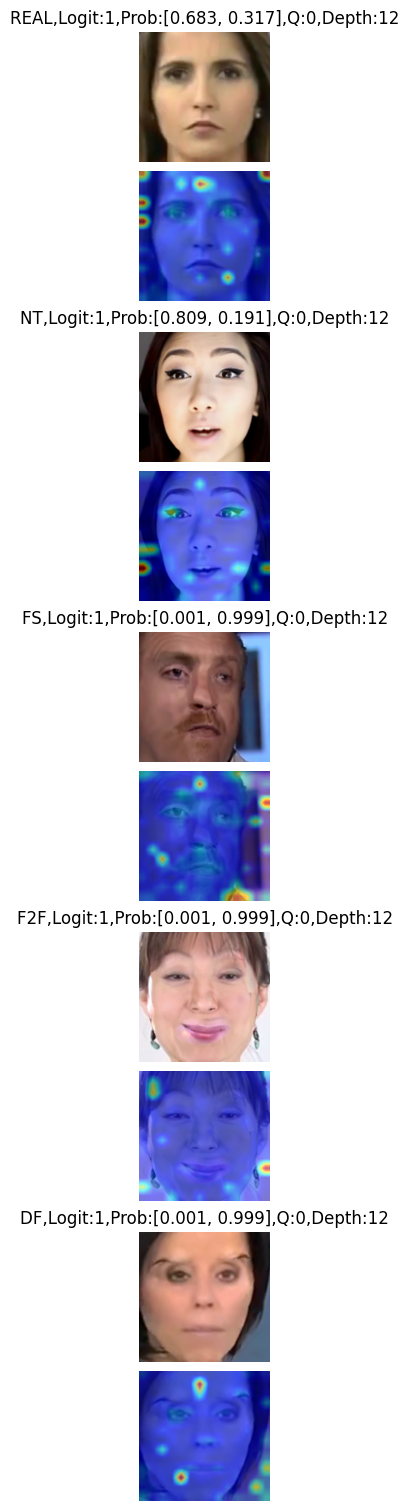

In [20]:
torch.cuda.empty_cache()

clip_heatmap_pairs = []
# Cs = list(range(model.decoder.num_classes))
# Ds = list([range(1,len(model.layer_indices+1)))
# Qs = list(range(model.decoder.num_classes))
Cs = [1]
Ds = [12]
Qs = [0]

# for dftype in ["NT","DF","FS"]:
# for dftype in ["REAL", "DF", "NT"]:
for dftype in ["REAL", "NT", "FS", "F2F", "DF"]:
    # for dftype in ["NT"]:
    c.types = [dftype]
    x = FFPP(c.clone(), num_frames, 4, transform, accelerator, split="test")
    _x = FFPP(c.clone(), num_frames, 4, _transform, accelerator, split="test")

    # select video index
    # vid_idx = next(i for i, d in enumerate(x.video_list) if d[2] == "691_732")
    # vid_idx = next(i for i, d in enumerate(x.video_list) if d[2] == "851_552")
    # vid_idx = next(i for i, d in enumerate(x.video_list) if d[2] == "691_732")
    # vid_idx = next(i for i, d in enumerate(x.video_list) if d[2] == "089")
    # vid_idx = next(i for i, d in enumerate(x.video_list) if "225" == d[2].split('_')[0])
    # vid_idx = next(i for i, d in enumerate(x.video_list) if "634" in d[2])
    # vid_idx = next(i for i, d in enumerate(x.video_list) if d[2] == "507_418")
    # vid_idx = next(i for i, d in enumerate(x.video_list) if d[0]=="DF" and d[2] == "855_801")
    # vid_idx = next(i for i, d in enumerate(x.video_list) if d[2] == "855")
    # vid_idx = 10
    vid_idx = random.randrange(0, len(x))

    # sample video
    clips, label, masks, speed, meta, task_index = x[vid_idx]
    _clips = _x[vid_idx][0]
    clips = torch.stack(clips)
    masks = torch.stack(masks)

    # select single clip
    clip = clips[0]
    mask = masks[0]
    _clip = _clips[0]

    # generate
    for logit in Cs:
        for depth in Ds:
            # interpret prediction
            _clip_relevance, probs = interpret(
                clip, mask, model, "cuda", logit_index=logit,
                start_layer=0, num_layer=depth, mode="all"
            )
            probs = [round(p, 3) for p in probs.flatten().tolist()]
            # heatmap for individual queries
            for q in Qs:
                flat_clip, flat_heatmap = show_clip_relevance(_clip, _clip_relevance, q)
                clip_heatmap_pairs.append(
                    (f"{dftype},Logit:{logit},Prob:{probs},Q:{q},Depth:{depth}", flat_clip, flat_heatmap)
                )


# plot figures
num_figures = 2 * len(clip_heatmap_pairs)
plt.figure(figsize=(1.5 * num_frames, 1.5 * num_figures), layout="constrained")
for i, data in enumerate(clip_heatmap_pairs):
    title, flat_clip, flat_heatmap = data
    plt.subplot(num_figures, 1, i * 2 + 1)
    plt.title(title)
    plt.imshow(flat_clip)
    plt.gca().axis("off")
    plt.subplot(num_figures, 1, i * 2 + 2)
    plt.imshow(flat_heatmap)
    plt.gca().axis("off")
plt.show()